In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df1 = pd.read_csv('denver_crime_8-26-2019.csv')
df2 = pd.read_csv('denver_offense_codes.csv')

In [3]:
#bring our dataframes together
df = df1.merge(df2)

In [4]:
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_NAME
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,...,1707251.0,-104.809881,39.773188,5,521,montbello,1,0,Unlawful discharge of a weapon,All Other Crimes
1,201872599,201872599521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,1/30/2018 10:14:00 PM,NaN,1/30/2018 10:14:00 PM,12900 BLOCK E ANDREWS DR,...,1711367.0,-104.841184,39.784667,5,521,montbello,1,0,Unlawful discharge of a weapon,All Other Crimes
2,201866465,201866465521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,1/28/2018 1:30:00 PM,1/28/2018 1:30:00 PM,1/28/2018 4:26:00 PM,14000 BLK E MAXWELL PL,...,1714526.0,-104.824755,39.793246,5,521,montbello,1,0,Unlawful discharge of a weapon,All Other Crimes
3,201872704,201872704521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,1/30/2018 11:08:00 PM,NaN,1/31/2018 8:43:00 AM,1700 BLOCK E BRUCE RANDOLPH AVE,...,1703764.0,-104.966880,39.764431,2,211,cole,1,0,Unlawful discharge of a weapon,All Other Crimes
4,2018255494,2018255494521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,4/17/2018 2:29:00 AM,NaN,4/17/2018 2:48:00 AM,900 BLOCK N NEWTON ST,...,1691766.0,-105.037222,39.731791,1,122,villa-park,1,0,Unlawful discharge of a weapon,All Other Crimes


In [5]:
df.shape

(507443, 21)

In [6]:
#convert date and time columns to datetime dtype
df.loc[:, 'FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df.loc[:, 'FIRST_OCCURRENCE_DATE'], format="%m/%d/%Y %I:%M:%S %p")

In [7]:
df.loc[:, 'REPORTED_DATE'] = pd.to_datetime(df.loc[:, 'REPORTED_DATE'], format="%m/%d/%Y %I:%M:%S %p")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507443 entries, 0 to 507442
Data columns (total 21 columns):
INCIDENT_ID               507443 non-null int64
OFFENSE_ID                507443 non-null int64
OFFENSE_CODE              507443 non-null int64
OFFENSE_CODE_EXTENSION    507443 non-null int64
OFFENSE_TYPE_ID           507443 non-null object
OFFENSE_CATEGORY_ID       507443 non-null object
FIRST_OCCURRENCE_DATE     507443 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      160658 non-null object
REPORTED_DATE             507443 non-null datetime64[ns]
INCIDENT_ADDRESS          457870 non-null object
GEO_X                     503263 non-null float64
GEO_Y                     503263 non-null float64
GEO_LON                   503263 non-null float64
GEO_LAT                   503263 non-null float64
DISTRICT_ID               507443 non-null int64
PRECINCT_ID               507443 non-null int64
NEIGHBORHOOD_ID           507443 non-null object
IS_CRIME                  507443 non-null 

In [9]:
#convert offense category names to category type (save memory)
df.loc[:, 'OFFENSE_CATEGORY_NAME'] = df.OFFENSE_CATEGORY_NAME.astype('category')

In [10]:
#remove columns with incomplete data
df = df.dropna(axis=1)

In [11]:
#check out how the dataframe is looking
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507443 entries, 0 to 507442
Data columns (total 15 columns):
INCIDENT_ID               507443 non-null int64
OFFENSE_ID                507443 non-null int64
OFFENSE_CODE              507443 non-null int64
OFFENSE_CODE_EXTENSION    507443 non-null int64
OFFENSE_TYPE_ID           507443 non-null object
OFFENSE_CATEGORY_ID       507443 non-null object
FIRST_OCCURRENCE_DATE     507443 non-null datetime64[ns]
REPORTED_DATE             507443 non-null datetime64[ns]
DISTRICT_ID               507443 non-null int64
PRECINCT_ID               507443 non-null int64
NEIGHBORHOOD_ID           507443 non-null object
IS_CRIME                  507443 non-null int64
IS_TRAFFIC                507443 non-null int64
OFFENSE_TYPE_NAME         507443 non-null object
OFFENSE_CATEGORY_NAME     507443 non-null category
dtypes: category(1), datetime64[ns](2), int64(8), object(4)
memory usage: 133.2 MB


In [12]:
#latest accurate date for the dataset is said to be 30 days prior to update date
latest_date = pd.to_datetime('August 26, 2019')
acc_date = latest_date - pd.Timedelta(30, unit='d')

In [13]:
#eliminate rows that occurred too recently to be deemed 'accurate'
df = df[df.FIRST_OCCURRENCE_DATE < acc_date]

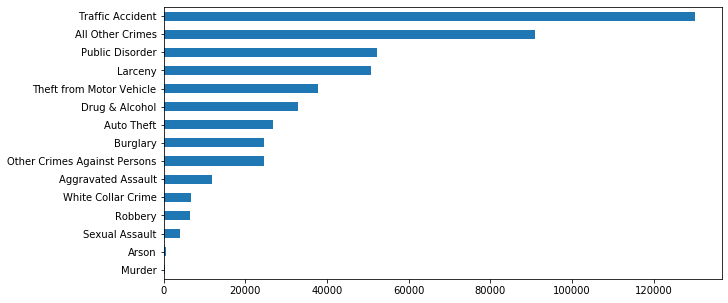

In [14]:
#graph the total incidents by their category name
df.OFFENSE_CATEGORY_NAME.value_counts().plot(kind='barh', legend=False, figsize=(10, 5))
plt.gca().invert_yaxis()
plt.show()

In [15]:
#eliminate 'Traffic Accident' rows --> not crime
df = df[df.IS_CRIME == 1]

In [30]:
#create a semi-flexible horizontal graph function for our dataset df
def graph_valcts_by_col(column, column2, val=None):
    if val == None:
        for value in df.loc[:, column].unique():
            category = df[df.loc[:, column] == value].loc[:, column2].value_counts() 
            if len(category) <= 20:
                category.plot(kind='barh', legend=False, figsize=(10,5), title='{} - Value Counts'.format(value))
                plt.xlabel('Number of Offenses')
                plt.ylabel(column2)
                plt.gca().invert_yaxis()
                plt.show()
            else:         
                other = category[20:].sum()
                top = category.nlargest(19)
                top['All others'] = other
                top.plot(kind='barh', legend=False, figsize=(10,5), title='{} - Value Counts'.format(value))
                plt.xlabel('Number of Offenses')
                plt.ylabel(column2)
                plt.gca().invert_yaxis()
                plt.show()
    else:
        value = val
        category = df[df.loc[:, column] == value].loc[:, column2].value_counts() 
        if len(category) <= 20:
            category.plot(kind='barh', legend=False, figsize=(10,5), title='{} - Value Counts'.format(value))
            plt.xlabel('Number of Offenses')
            plt.ylabel(column2)
            plt.gca().invert_yaxis()
            plt.show()
        else:         
            other = category[20:].sum()
            top = category.nlargest(19)
            top['All others'] = other
            top.plot(kind='barh', legend=False, figsize=(10,5), title='{} - Value Counts'.format(value))
            plt.xlabel('Number of Offenses')
            plt.ylabel(column2)
            plt.gca().invert_yaxis()
            plt.show()

In [17]:
#get rid of redundant columns (mostly useful just for merging of initial datasets)
df = df.drop(['OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION'], axis=1)

In [18]:
#quick look at overview of data
df.describe(include='all')

,INCIDENT_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_NAME
count,3.704740e+05,370474,370474,370474.000000,370474.000000,370474,370474.0,370474.000000,370474,370474
unique,NaN,234794,312461,NaN,NaN,78,NaN,NaN,196,14
top,NaN,2015-01-01 00:00:00,2017-02-13 09:00:00,NaN,NaN,five-points,NaN,NaN,Traffic offense - other,All Other Crimes
freq,NaN,26,9,NaN,NaN,21925,NaN,NaN,32810,90911
first,NaN,2014-01-02 00:00:00,2014-01-02 00:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-07-26 23:44:00,2019-08-23 00:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.393217e+09,NaN,NaN,3.573384,374.867680,NaN,1.0,0.000715,NaN,NaN
std,9.963398e+09,NaN,NaN,1.797164,180.290005,NaN,0.0,0.026736,NaN,NaN
min,2.019600e+04,NaN,NaN,1.000000,111.000000,NaN,1.0,0.000000,NaN,NaN
25%,2.015168e+09,NaN,NaN,2.000000,221.000000,NaN,1.0,0.000000,NaN,NaN


In [19]:
df.loc[:, 'NEIGHBORHOOD_ID'] = df.NEIGHBORHOOD_ID.str.replace('-', ' ').str.title()

In [20]:
df.rename(columns={'NEIGHBORHOOD_ID': 'NEIGHBORHOOD_NAME'}, inplace=True)

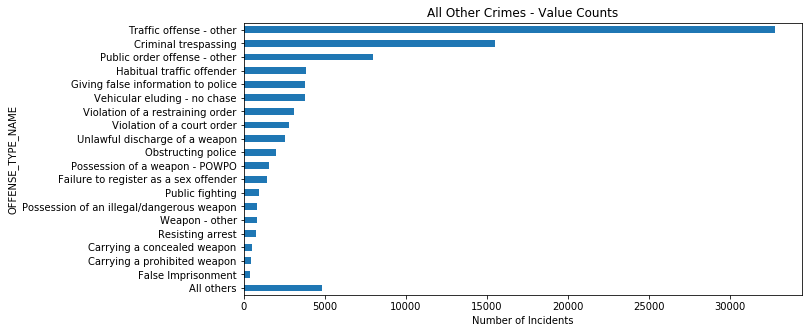

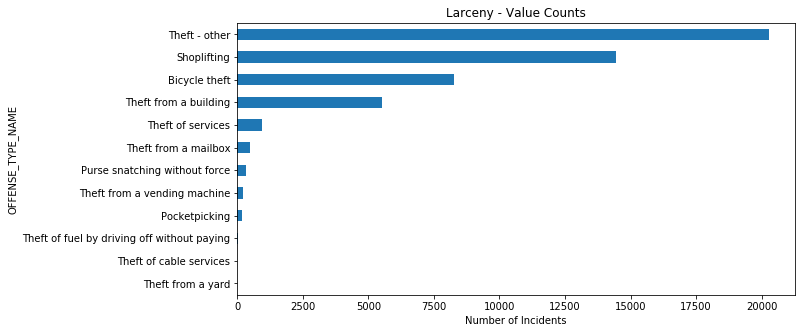

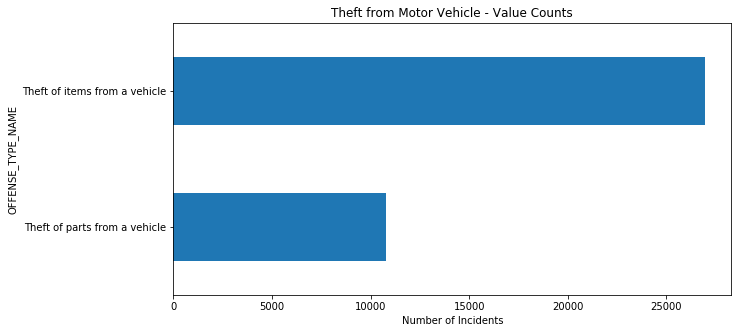

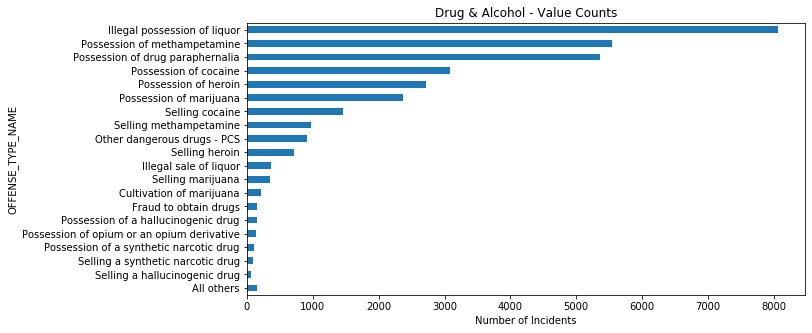

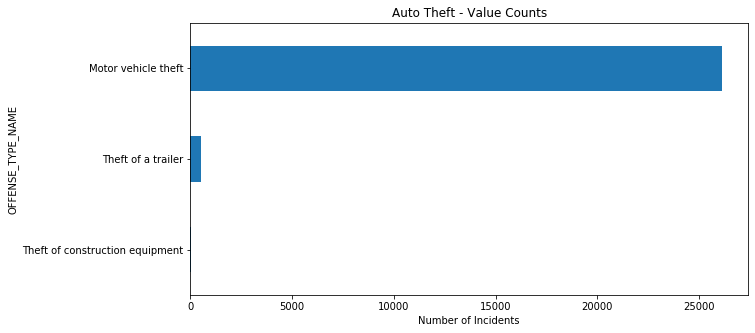

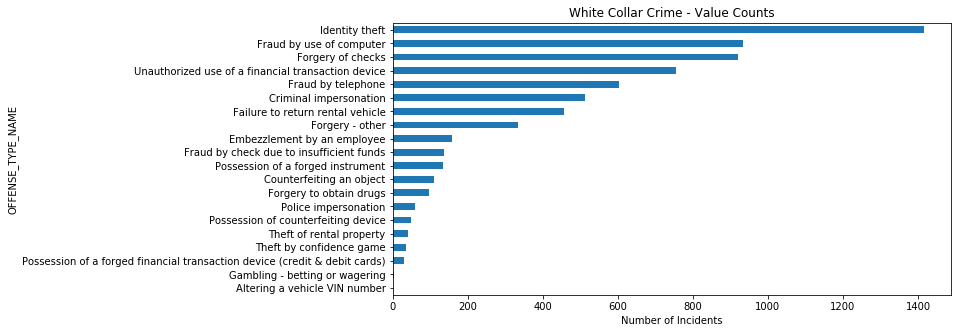

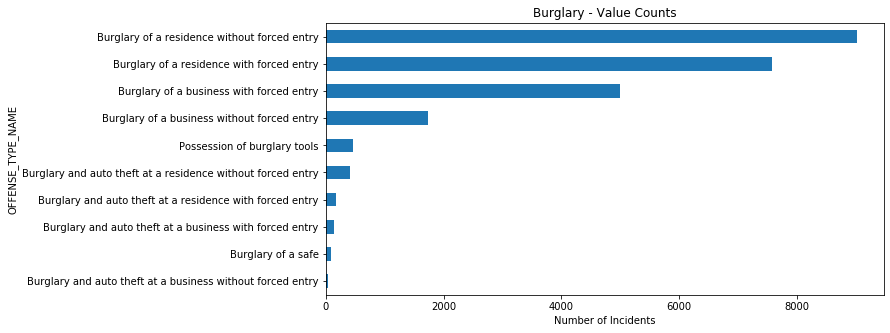

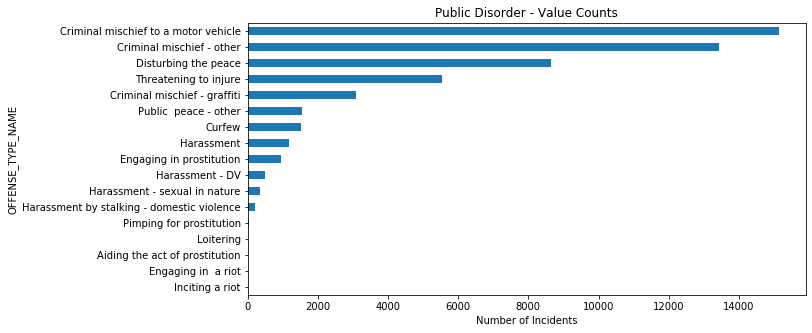

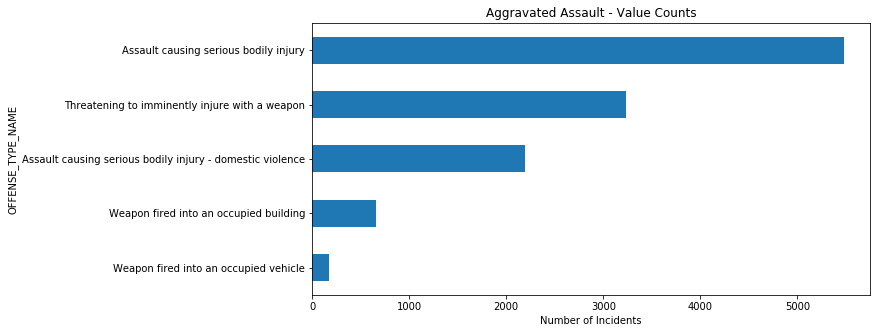

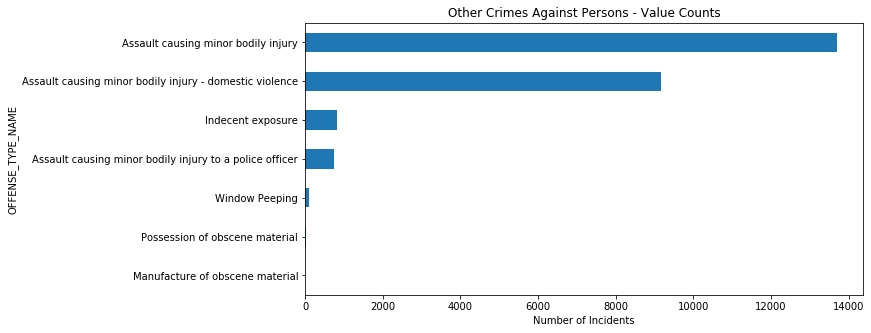

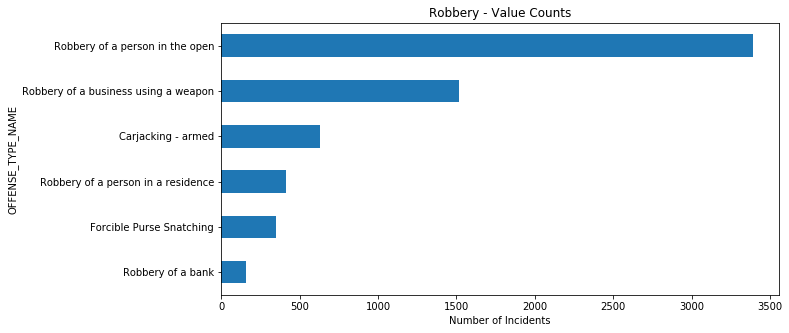

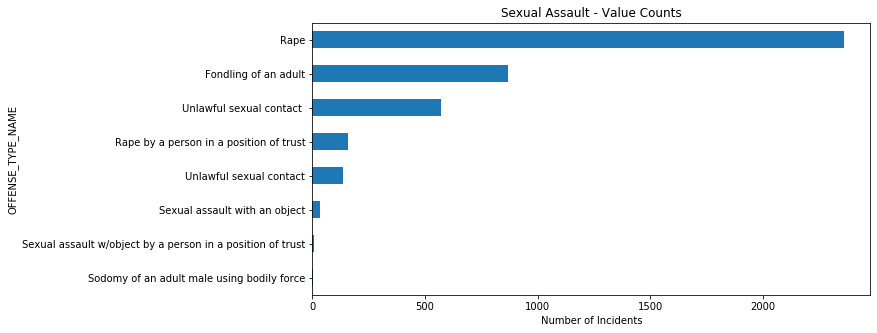

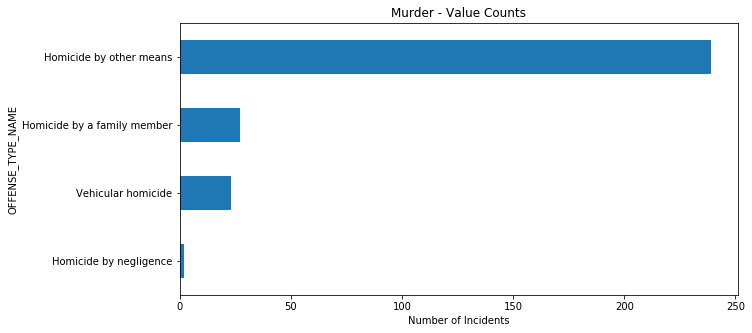

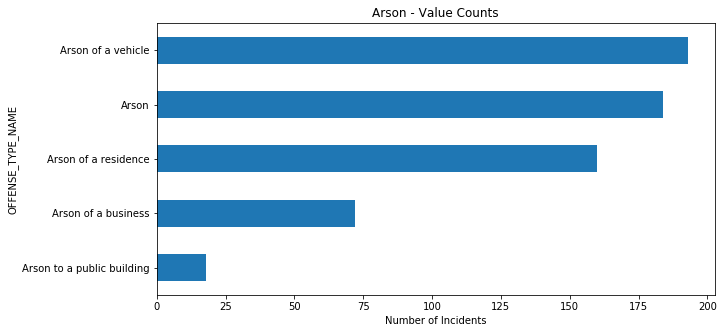

In [21]:
graph_valcts_by_col('OFFENSE_CATEGORY_NAME', 'OFFENSE_TYPE_NAME')

In [22]:
df.OFFENSE_CATEGORY_NAME.value_counts()
#why does 'Traffic Accident' still appear here?'

All Other Crimes                90911
Public Disorder                 52162
Larceny                         50727
Theft from Motor Vehicle        37725
Drug & Alcohol                  33016
Auto Theft                      26677
Burglary                        24655
Other Crimes Against Persons    24564
Aggravated Assault              11738
White Collar Crime               6790
Robbery                          6457
Sexual Assault                   4134
Arson                             627
Murder                            291
Traffic Accident                    0
Name: OFFENSE_CATEGORY_NAME, dtype: int64

In [23]:
#MULT_COUNTS = pd.DataFrame(df.INCIDENT_ID.value_counts())
#MULT_COUNTS.reset_index(inplace=True)
#cols = ['INCIDENT_ID', 'TOTAL_INCIDENT_COUNTS']
#MULT_COUNTS.columns = cols
#df = df.merge(MULT_COUNTS)

In [24]:
#df.loc[:, 'MULT_INCIDENT'] = df.TOTAL_INCIDENT_COUNTS > 1

In [91]:
df.describe(include='all')

,INCIDENT_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,IS_CRIME,IS_TRAFFIC,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_NAME
count,3.704740e+05,370474,370474,370474.000000,370474.000000,370474,370474.0,370474.000000,370474,370474
unique,NaN,234794,312461,NaN,NaN,78,NaN,NaN,196,14
top,NaN,2015-01-01 00:00:00,2017-02-13 09:00:00,NaN,NaN,Five Points,NaN,NaN,Traffic offense - other,All Other Crimes
freq,NaN,26,9,NaN,NaN,21925,NaN,NaN,32810,90911
first,NaN,2014-01-02 00:00:00,2014-01-02 00:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-07-26 23:44:00,2019-08-23 00:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.393217e+09,NaN,NaN,3.573384,374.867680,NaN,1.0,0.000715,NaN,NaN
std,9.963398e+09,NaN,NaN,1.797164,180.290005,NaN,0.0,0.026736,NaN,NaN
min,2.019600e+04,NaN,NaN,1.000000,111.000000,NaN,1.0,0.000000,NaN,NaN
25%,2.015168e+09,NaN,NaN,2.000000,221.000000,NaN,1.0,0.000000,NaN,NaN


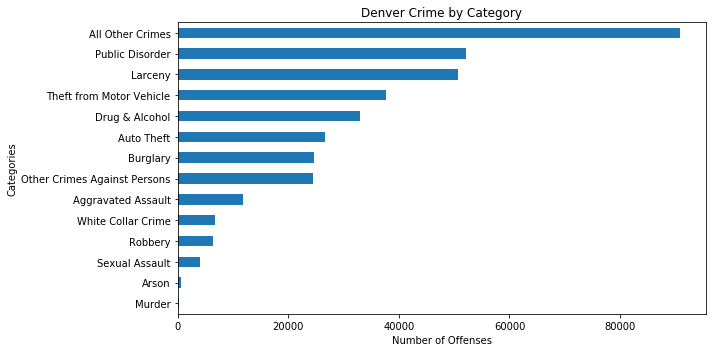

In [25]:
#decent looking dataframe - questions of interest?
#What are the most prominent types of crime in Denver?
df.OFFENSE_CATEGORY_NAME.value_counts().nlargest(14).plot(kind='barh', figsize=(10, 5), title='Denver Crime by Category')
plt.gca().invert_yaxis()
plt.xlabel('Number of Offenses')
plt.ylabel('Categories')
plt.tight_layout()
plt.show()

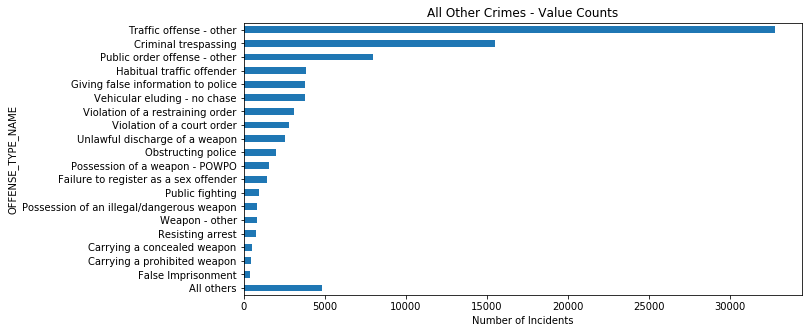

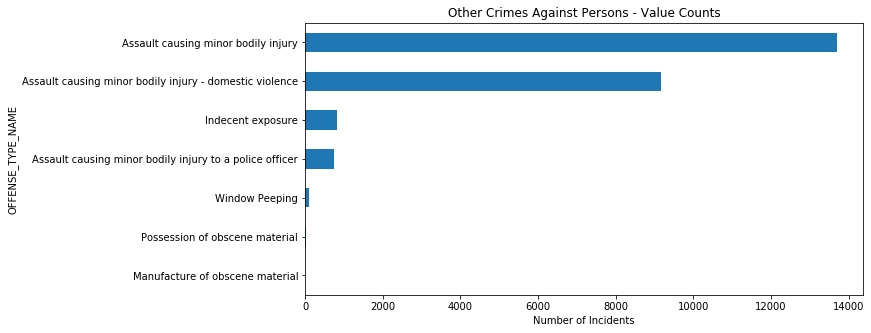

In [26]:
#'All Other Crimes' and 'Other Crimes Against Persons' don't seem very descriptive - drilling in should be useful
graph_valcts_by_col('OFFENSE_CATEGORY_NAME', 'OFFENSE_TYPE_NAME', val='All Other Crimes')
graph_valcts_by_col('OFFENSE_CATEGORY_NAME', 'OFFENSE_TYPE_NAME', val='Other Crimes Against Persons')

In [27]:
#Seems like Denver's categorization of crime could use an update, not sure why Assault doesn't have its own category, also
#wonder why 'Traffic offense - other' isn't a category in and of itself - it certainly contains enough occurrences to warrant
#the change, in fact it appears there are a few more traffic related crimes on this list, we can get an idea of all others 
#using a quick value count
df[df.OFFENSE_CATEGORY_NAME == 'All Other Crimes'].OFFENSE_TYPE_NAME.value_counts()[20:]

Smuggle contraband to prisoner                                              315
Failure to appear                                                           308
Assault causing serious bodily injury of a police officer using a weapon    306
Flourishing of a weapon                                                     281
Vehicular assault                                                           242
Vehicular eluding                                                           229
Property crimes - other                                                     227
Kidnap an adult                                                             226
Other environmental or animal offense                                       219
Domestic violence kidnapping                                                179
Bomb threat                                                                 171
Possession of fireworks                                                     170
Reckless endangerment                   

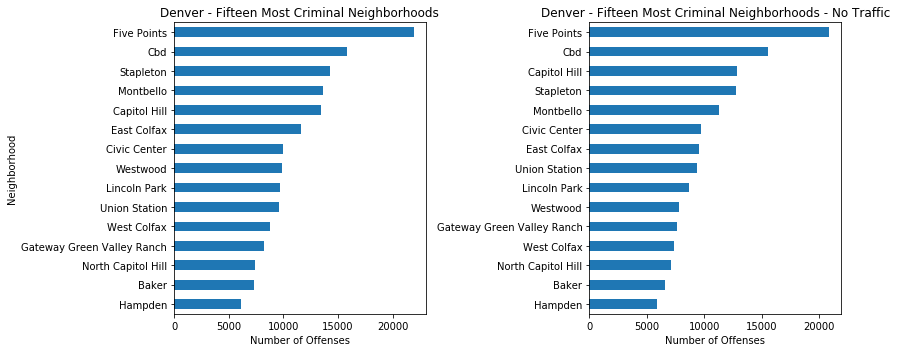

In [124]:
#looks like even more assualt is hidden within this 'All Other Crimes' category...
#we can look into the most criminal neighborhoods now
plt.subplot(1,2,1)
df.NEIGHBORHOOD_NAME.value_counts().nlargest(15).plot(kind='barh', figsize=(12,5), title='Denver - Fifteen Most Criminal Neighborhoods')
plt.xlabel('Number of Offenses')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.subplot(1,2,2)
df[df.OFFENSE_TYPE_NAME != 'Traffic offense - other'].NEIGHBORHOOD_NAME.value_counts().nlargest(15).plot(kind='barh', figsize=(12,5), title='Denver - Fifteen Most Criminal Neighborhoods - No Traffic')
plt.xlabel('Number of Offenses')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

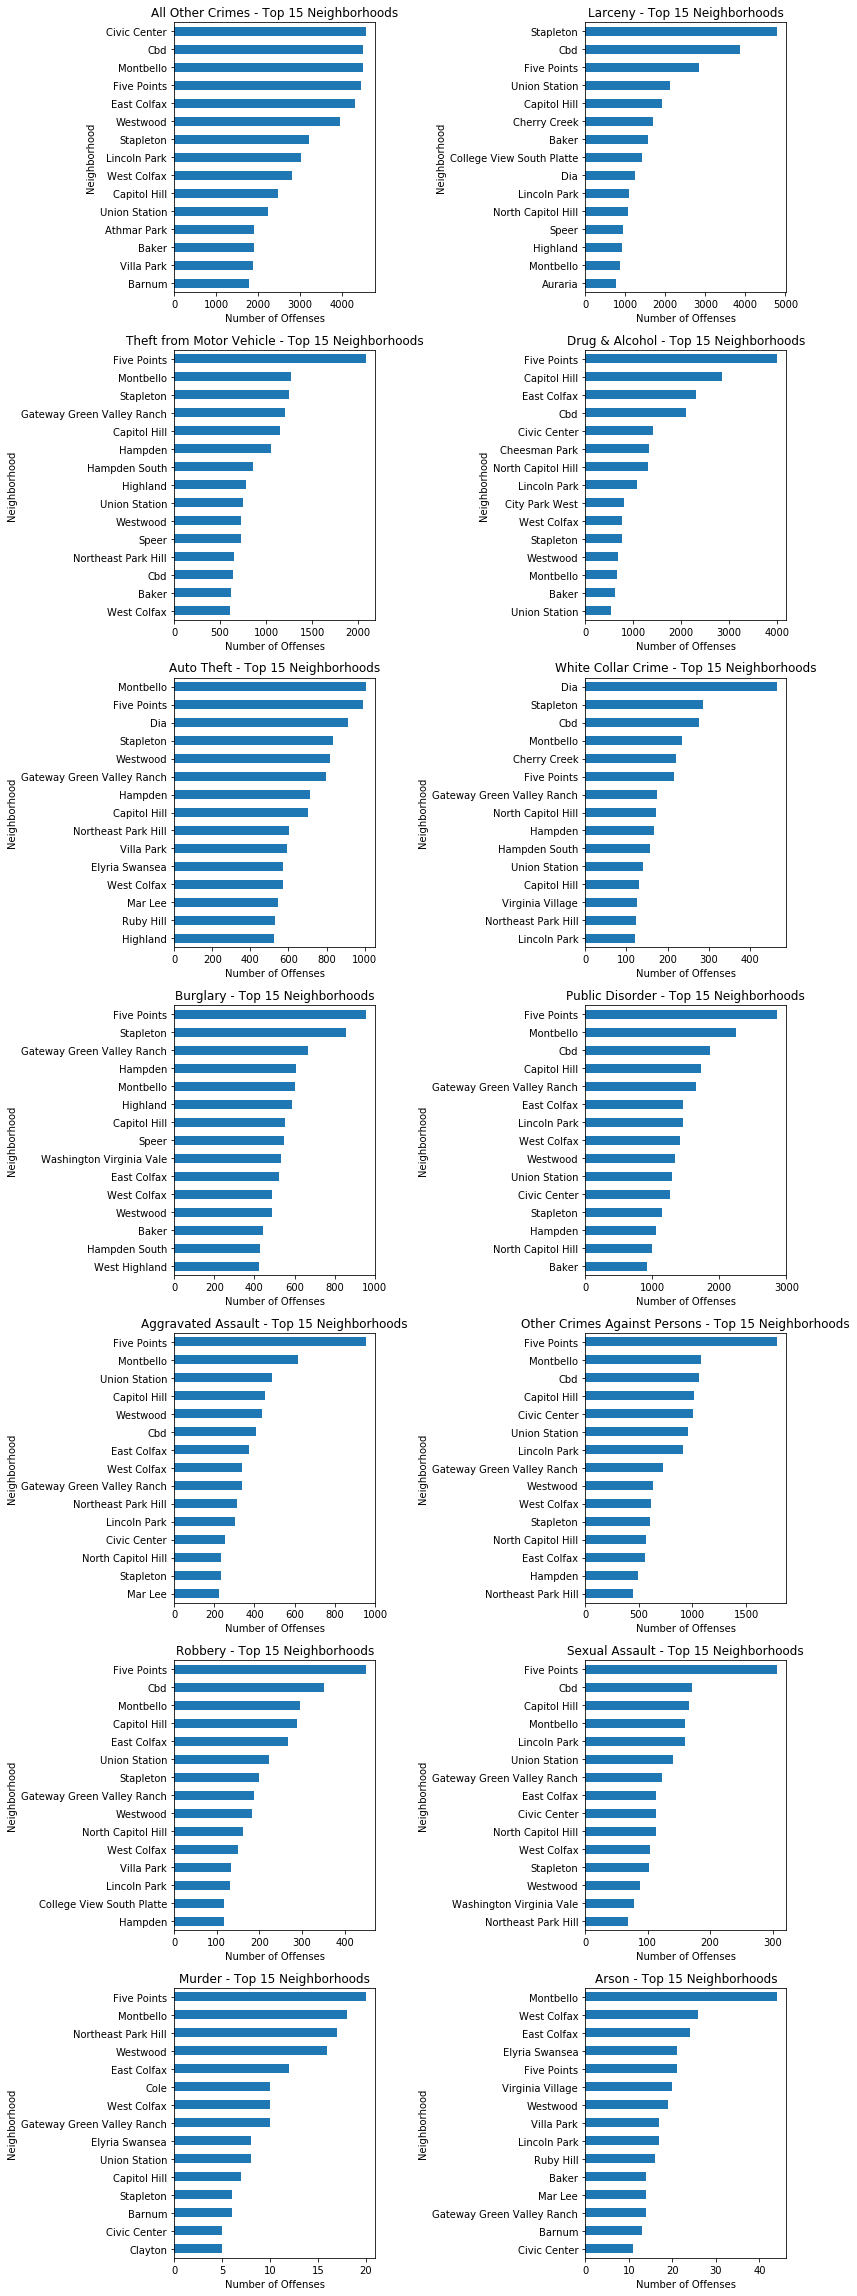

In [136]:
#Taking 'Traffic offense - other' out of the equation moves Capitol Hill up two ranks - above both Stapleton and Montbello. We
#also see Gateway Green Valley Ranch swap with West Colfax, Union Station moves up two positions and East Colfax swaps with 
#Civic Center. What will we see when we sort neighborhoods by category type?
plt.figure(figsize=(12,32))
graph_ct = 1
for value in df.OFFENSE_CATEGORY_NAME.unique():
    plt.subplot(7, 2, graph_ct)
    df[df.OFFENSE_CATEGORY_NAME == value].NEIGHBORHOOD_NAME.value_counts().nlargest(15).plot(kind='barh',
                                                                                             title='{} - Top 15 Neighborhoods'.format(value))
    plt.ylabel('Neighborhood')
    plt.xlabel('Number of Offenses')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    graph_ct += 1
plt.show()                                                                                             

In [230]:
ranks = pd.DataFrame(index=df.NEIGHBORHOOD_NAME.unique())

In [231]:
for value in df.OFFENSE_CATEGORY_NAME.unique():
    x = pd.DataFrame(df[df.OFFENSE_CATEGORY_NAME == value].NEIGHBORHOOD_NAME.value_counts().rank(ascending=False))
    x.rename(columns={'NEIGHBORHOOD_NAME': str(value)}, inplace=True)
    ranks = ranks.join(x, how='outer')

In [232]:
ranks.loc[:, 'Total Score'] = ranks.sum(axis=1)

In [284]:
comp_top15 = pd.DataFrame(ranks.loc[ranks.sort_values('Total Score').loc[:, 'Total Score'].nsmallest(15).index, :].loc[:, 'Total Score'].rank())
comp_top15.columns = ['cat_rank']
comp_top15 = comp_top15.join(pd.DataFrame(df.NEIGHBORHOOD_NAME.value_counts().nlargest(15).rank(ascending=False)))
comp_top15.loc[:, 'diff'] = comp_top15.NEIGHBORHOOD_NAME - comp_top15.cat_rank
comp_top15.columns = ['cat_rank', 'occ_rank', 'occ-cat_diff']

In [286]:
comp_top15

,cat_rank,occ_rank,occ-cat_diff
Five Points,1.0,1.0,0.0
Montbello,2.0,4.0,2.0
Capitol Hill,3.0,5.0,2.0
Stapleton,4.0,3.0,-1.0
East Colfax,5.0,6.0,1.0
West Colfax,6.0,11.0,5.0
Gateway Green Valley Ranch,7.0,12.0,5.0
Cbd,8.0,2.0,-6.0
Westwood,9.0,8.0,-1.0
Lincoln Park,10.0,9.0,-1.0


In [287]:
ranks.loc[comp_top15.index]

,All Other Crimes,Larceny,Theft from Motor Vehicle,Drug & Alcohol,Auto Theft,White Collar Crime,Burglary,Public Disorder,Aggravated Assault,Other Crimes Against Persons,Robbery,Sexual Assault,Murder,Arson,Total Score
Five Points,4.0,3.0,1.0,1.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.5,28.5
Montbello,3.0,14.0,2.0,13.0,1.0,4.0,5.0,2.0,2.0,2.0,3.0,4.5,2.0,1.0,58.5
Capitol Hill,10.0,5.0,5.0,2.0,8.0,12.0,7.0,4.0,4.0,4.0,4.0,3.0,11.0,17.0,96.0
Stapleton,7.0,1.0,3.0,11.0,4.0,2.0,2.0,12.0,14.0,11.0,7.0,12.0,12.5,27.5,126.0
East Colfax,5.0,28.0,22.0,3.0,16.0,22.5,10.0,6.0,7.0,13.0,5.0,8.5,5.0,3.0,154.0
West Colfax,9.0,16.0,15.0,10.0,12.0,24.5,11.0,8.0,8.0,10.0,11.0,11.0,7.0,2.0,154.5
Gateway Green Valley Ranch,21.5,17.0,4.0,42.0,6.0,7.0,3.0,5.0,9.0,8.0,8.0,7.0,7.0,12.0,156.5
Cbd,2.0,2.0,13.0,4.0,36.0,3.0,47.0,3.0,6.0,3.0,2.0,2.0,18.5,22.5,164.0
Westwood,6.0,41.0,10.0,12.0,5.0,22.5,12.0,9.0,5.0,9.0,9.0,13.0,4.0,7.0,164.5
Lincoln Park,8.0,10.0,19.5,8.0,18.0,15.0,33.0,7.0,11.0,7.0,13.0,4.5,28.5,8.5,191.0


From this quick ranking score, we can find the most criminal neighborhoods by their prevalence in a particular crime category rather than by the actual counts of crime, this is useful in comparing the top categories of crime for a particular neighborhood, rather than the number of occurrences.

### Thoughts on some Neighborhoods
1. Five Points holds the top spot for nine of the fourteen categories. There is also only one category that lands higher than fifth, White Collar Crime. This shows that five points not only has the most occurrences of crime, but that basically every single category of crime is prevalent here.
2. Montbello may not have as much overall crime as CBD or Stapleton, but ranks higher categorically than the other two. This indicates more variation in types of crime in Montbello. It holds twelve of the fourteen top five positions and all fourteen categories rank in the top fourteen of any neighborhood.
3. Capitol Hill is similar in vein to Montbello, however the variation of crime looks different (ranks higher in Larceny, Drug and Alcohol, and Sexual Assualt). Thirteen of the fourteen categories land in the top fifteen - the only exception being arson (where Montbello ranks supreme).
4. Stapleton, like Capitol Hill, has thirteen of the fourteen categories in the top fifteen rank with the exception of arson. However, it appears certain categories are more prevalent than others. Five of the fourteen categories land in the top five of any other neighborhood, these include: Larceny(rank 1), Theft from motor vehicle(3), Auto theft(4), White Collar Crime(2), and Burglary(2). Based on this, it would appear Stapleton's main categories of crime seem to be theft related.
5. East and West Colfax have almost an identical score, could be of interest to see how closely they are related to one another.

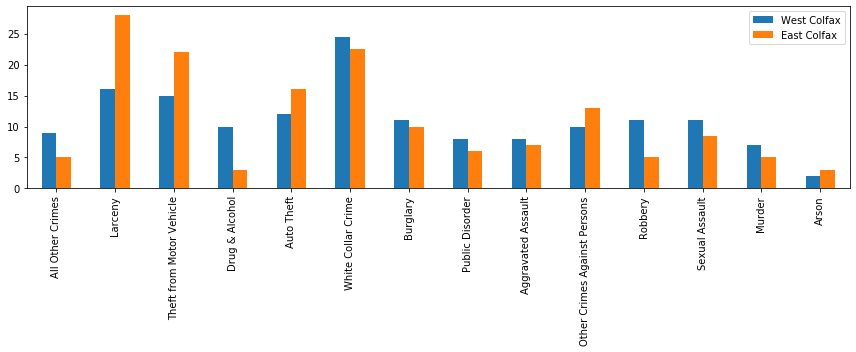

In [238]:
ranks.loc[('West Colfax', 'East Colfax'), 'All Other Crimes':'Arson'].transpose().plot(kind='bar', figsize=(12,5))
plt.tight_layout()
plt.show()

Their rankings certainly appear to be quite similar. This is interesting, because these neighborhoods are actually about 8 miles apart from one another, they just center around the same street - Colfax Ave. Drug and Alcohol crime appears to be more prevalent in East Colfax than West Colfax, as is robbery. However, larceny and theft from motor vehicle are more prevalent in West Colfax. Perhaps most interesting is the that these two neighborhoods both rank so highly in arson! West Colfax is second and East Colfax is third.

In [291]:
ranks.loc[comp_top15.index]

,All Other Crimes,Larceny,Theft from Motor Vehicle,Drug & Alcohol,Auto Theft,White Collar Crime,Burglary,Public Disorder,Aggravated Assault,Other Crimes Against Persons,Robbery,Sexual Assault,Murder,Arson,Total Score
Five Points,4.0,3.0,1.0,1.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.5,28.5
Montbello,3.0,14.0,2.0,13.0,1.0,4.0,5.0,2.0,2.0,2.0,3.0,4.5,2.0,1.0,58.5
Capitol Hill,10.0,5.0,5.0,2.0,8.0,12.0,7.0,4.0,4.0,4.0,4.0,3.0,11.0,17.0,96.0
Stapleton,7.0,1.0,3.0,11.0,4.0,2.0,2.0,12.0,14.0,11.0,7.0,12.0,12.5,27.5,126.0
East Colfax,5.0,28.0,22.0,3.0,16.0,22.5,10.0,6.0,7.0,13.0,5.0,8.5,5.0,3.0,154.0
West Colfax,9.0,16.0,15.0,10.0,12.0,24.5,11.0,8.0,8.0,10.0,11.0,11.0,7.0,2.0,154.5
Gateway Green Valley Ranch,21.5,17.0,4.0,42.0,6.0,7.0,3.0,5.0,9.0,8.0,8.0,7.0,7.0,12.0,156.5
Cbd,2.0,2.0,13.0,4.0,36.0,3.0,47.0,3.0,6.0,3.0,2.0,2.0,18.5,22.5,164.0
Westwood,6.0,41.0,10.0,12.0,5.0,22.5,12.0,9.0,5.0,9.0,9.0,13.0,4.0,7.0,164.5
Lincoln Park,8.0,10.0,19.5,8.0,18.0,15.0,33.0,7.0,11.0,7.0,13.0,4.5,28.5,8.5,191.0


6. Gateway / Green Valley Ranch (along with West Colfax) had the greatest increase in position, this makes sense because it ranks very highly in numerous categories, but because one or two categories rank lower (especially 'All Other Crimes' which is offense heavy) the number of total offenses is not as high. Even though the majority of the categories rank in the top fifteen, we can see that 'All Other Crimes' and especially 'Drug & Alcohol' rank much lower than most of the ranks on this dataslice. Could this be because it is a much greater distance from downtown denver than most of these neighborhoods? I wonder if there is a correllation between location and category of crime - this could be a hint that there is.
7. CBD (Central Business District) is right in the heart of downtown Denver, mostly makes sense. If you consider that some of these crime categories require certain personal properties to be present (Theft from Motor Vehicle - car, Auto Theft - car, Burglary - house) then it makes sense why CBD would rank lower in these categories. These ranks aren't very surprising - also consider the higher law enforcement presence in these areas would probably have an effect on many of these categories.
8. Perhaps the most interesting neighborhood on this list is Northeast Park Hill, where its highest ranking is murder. It has some top fifteen categories, but eight of the fourteen categories are over fifteen. I do wonder why the murder rank is so much higher here though.

In [293]:
df[(df.NEIGHBORHOOD_NAME == 'Northeast Park Hill') & (df.OFFENSE_CATEGORY_NAME == 'Murder')].sort_values('FIRST_OCCURRENCE_DATE')

,INCIDENT_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,IS_CRIME,IS_TRAFFIC,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_NAME
460657,2014332207,2014-06-28 18:35:00,2014-06-28 18:41:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
506502,2014604532,2014-11-13 00:20:00,2014-11-13 00:21:00,2,221,Northeast Park Hill,1,0,Homicide by a family member,Murder
460810,2015144151,2015-03-15 21:21:00,2015-03-15 22:31:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
460792,2015496282,2015-08-28 18:53:00,2015-08-28 19:31:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
460831,2015678513,2015-11-19 23:00:00,2015-11-20 07:25:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
460761,2015695114,2015-11-29 02:45:00,2015-11-29 05:47:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
460760,2016151157,2016-03-09 20:15:00,2016-03-09 21:48:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
460688,2016347798,2016-06-03 20:13:00,2016-06-03 21:59:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder
506481,2016650107,2016-10-10 18:40:00,2016-10-10 18:40:00,2,221,Northeast Park Hill,1,1,Vehicular homicide,Murder
460725,2017501092,2017-07-29 02:44:00,2017-07-29 02:53:00,2,221,Northeast Park Hill,1,0,Homicide by other means,Murder


In [301]:
df[(df.NEIGHBORHOOD_NAME == 'Northeast Park Hill') & (df.OFFENSE_CATEGORY_NAME == 'Murder')].shape

(17, 10)

Looks like seventeen murders occurred in Northeast Park Hill since the beginning of 2014. In comparison to the other crimes, I wonder why.

In [125]:
#What about the most dangerous/violent neighborhoods?
#There are a few ideas on what violent crime includes, for the purpose of this project the FBI's UCR classification will be
#used, the definition is as follows:

In the FBI’s Uniform Crime Reporting (UCR) Program, violent crime is composed of four offenses:  murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force.

In [312]:
#In order to create a DataFrame called 'v_crime' we need to find the relevant rows from the original DataFrame. This will likely
#require some filtering and value counting to ensure we get the relevant rows. Murder should be relatively easy, since it has
#the least amount of occurrences.

In [315]:
murder = df[df.OFFENSE_CATEGORY_NAME == 'Murder']
#checked for manslaughter in OFFENSE_TYPE_NAME, but did not return any results

In [340]:
def cat():
    return df.OFFENSE_CATEGORY_NAME.value_counts()

In [321]:
df[(df.OFFENSE_CATEGORY_NAME == 'Sexual Assault')].OFFENSE_TYPE_NAME.value_counts()

Rape                                                          2359
Fondling of an adult                                           868
Unlawful sexual contact                                        570
Rape by a person in a position of trust                        158
Unlawful sexual contact                                        135
Sexual assault with an object                                   33
Sexual assault w/object by a person in a position of trust       8
Sodomy of an adult male using bodily force                       3
Name: OFFENSE_TYPE_NAME, dtype: int64

From this we can see that this is all Rape/sexual assualt, so we should make a DataFrame for it. But first let's see if there are any other sexual crimes that may need to be considered.

In [324]:
df[(df.OFFENSE_CATEGORY_NAME != 'Sexual Assault')].OFFENSE_TYPE_NAME.str.contains('sex', case=False).sum()

1879

Looks like there are 1,879 cases where this is true, we can dig in deeper to see what these OFFENSE_TYPE_NAME series contains.

In [336]:
df[(df.OFFENSE_CATEGORY_NAME != 'Sexual Assault')][df[(df.OFFENSE_CATEGORY_NAME != 'Sexual Assault')].OFFENSE_TYPE_NAME.str.contains('sex', case=False)].OFFENSE_TYPE_NAME.value_counts()

Failure to register as a sex offender    1413
Harassment - sexual in nature             344
Sex offender registration violation       122
Name: OFFENSE_TYPE_NAME, dtype: int64

Based on the above, it does not appear these need to be added to the violent crimes DataFrame. Sexual harassment could be included, but without further details of this type, or further classification, it is not right to add.

In [337]:
rape = df[(df.OFFENSE_CATEGORY_NAME == 'Sexual Assault')]

On to robbery then!

In [341]:
cat()

All Other Crimes                90911
Public Disorder                 52162
Larceny                         50727
Theft from Motor Vehicle        37725
Drug & Alcohol                  33016
Auto Theft                      26677
Burglary                        24655
Other Crimes Against Persons    24564
Aggravated Assault              11738
White Collar Crime               6790
Robbery                          6457
Sexual Assault                   4134
Arson                             627
Murder                            291
Traffic Accident                    0
Name: OFFENSE_CATEGORY_NAME, dtype: int64

In [347]:
def cat_bool(value):
    return df.OFFENSE_CATEGORY_NAME == value

In [351]:
def types_from_cat(value):
    return df[cat_bool(value)].OFFENSE_TYPE_NAME.value_counts()

In [352]:
types_from_cat('Larceny')

Theft - other                                  20264
Shoplifting                                    14461
Bicycle theft                                   8282
Theft from a building                           5516
Theft of services                                935
Theft from a mailbox                             468
Purse snatching without force                    345
Theft from a vending machine                     234
Pocketpicking                                    187
Theft of fuel by driving off without paying       33
Theft of cable services                            1
Theft from a yard                                  1
Name: OFFENSE_TYPE_NAME, dtype: int64

These are all non-violent, no need to add.

In [356]:
cat()

All Other Crimes                90911
Public Disorder                 52162
Larceny                         50727
Theft from Motor Vehicle        37725
Drug & Alcohol                  33016
Auto Theft                      26677
Burglary                        24655
Other Crimes Against Persons    24564
Aggravated Assault              11738
White Collar Crime               6790
Robbery                          6457
Sexual Assault                   4134
Arson                             627
Murder                            291
Traffic Accident                    0
Name: OFFENSE_CATEGORY_NAME, dtype: int64

In [359]:
types_from_cat('Other Crimes Against Persons')

Assault causing minor bodily injury                        13693
Assault causing minor bodily injury - domestic violence     9168
Indecent exposure                                            823
Assault causing minor bodily injury to a police officer      736
Window Peeping                                               106
Possession of obscene material                                32
Manufacture of obscene material                                6
Name: OFFENSE_TYPE_NAME, dtype: int64

Good to look at these, however assualt with minor bodily injury is not considered aggravated assualt - so it will not be included in violent crimes.

In [360]:
cat()

All Other Crimes                90911
Public Disorder                 52162
Larceny                         50727
Theft from Motor Vehicle        37725
Drug & Alcohol                  33016
Auto Theft                      26677
Burglary                        24655
Other Crimes Against Persons    24564
Aggravated Assault              11738
White Collar Crime               6790
Robbery                          6457
Sexual Assault                   4134
Arson                             627
Murder                            291
Traffic Accident                    0
Name: OFFENSE_CATEGORY_NAME, dtype: int64

In [374]:
types_from_cat('Robbery')

Robbery of a person in the open         3389
Robbery of a business using a weapon    1519
Carjacking - armed                       631
Robbery of a person in a residence       410
Forcible Purse Snatching                 348
Robbery of a bank                        160
Name: OFFENSE_TYPE_NAME, dtype: int64

In [375]:
robbery = df[sbool('Robbery')]

Last category is aggravated assault, luckily enough - all these incidents are nicely packaged in the OFFENSE_CATEGORY_NAME column under 'Aggravated Assault'.

In [378]:
types_from_cat('Aggravated Assault')

Assault causing serious bodily injury                        5477
Threatening to imminently injure with a weapon               3236
Assault causing serious bodily injury - domestic violence    2196
Weapon fired into an occupied building                        659
Weapon fired into an occupied vehicle                         170
Name: OFFENSE_TYPE_NAME, dtype: int64

In [379]:
assault = df[sbool('Aggravated Assault')]

In [380]:
v_crime = pd.concat([murder, rape, robbery, assault])

In [381]:
len(murder) + len(rape) + len(robbery) + len(assault)

22620

In [382]:
v_crime.shape

(22620, 10)

## Success! We have our violent crime DataFrame `v_crime`!

So, the question was, what neighborhoods have the most violent crime? But quick aside, how much of the total crime is actually violent crime?

In [390]:
len(v_crime)/len(df)

0.0610569162748263

We can see out of all the crime that occurs in Denver, only 6.1% is violent. 

In [415]:
v_crime.NEIGHBORHOOD_NAME.value_counts().nlargest(10).index

Index(['Five Points', 'Montbello', 'Cbd', 'Capitol Hill', 'Union Station',
       'East Colfax', 'Westwood', 'Gateway Green Valley Ranch', 'West Colfax',
       'Lincoln Park'],
      dtype='object')

By nearly 700 occurrances, Five Points again leads the way. Let's look at its breakdown.

In [398]:
def v_types_from_n(value):
    return v_crime[v_crime.NEIGHBORHOOD_NAME == value].OFFENSE_TYPE_NAME.value_counts()
def v_cats_from_n(value):
    return v_crime[v_crime.NEIGHBORHOOD_NAME == value].OFFENSE_CATEGORY_NAME.value_counts()

In [404]:
v_types_from_n('Five Points')

Assault causing serious bodily injury                        570
Robbery of a person in the open                              346
Threatening to imminently injure with a weapon               229
Rape                                                         194
Assault causing serious bodily injury - domestic violence    124
Fondling of an adult                                          66
Unlawful sexual contact                                       38
Robbery of a business using a weapon                          38
Carjacking - armed                                            28
Weapon fired into an occupied building                        25
Homicide by other means                                       20
Forcible Purse Snatching                                      19
Robbery of a person in a residence                            17
Weapon fired into an occupied vehicle                          6
Sexual assault with an object                                  4
Rape by a person in a pos

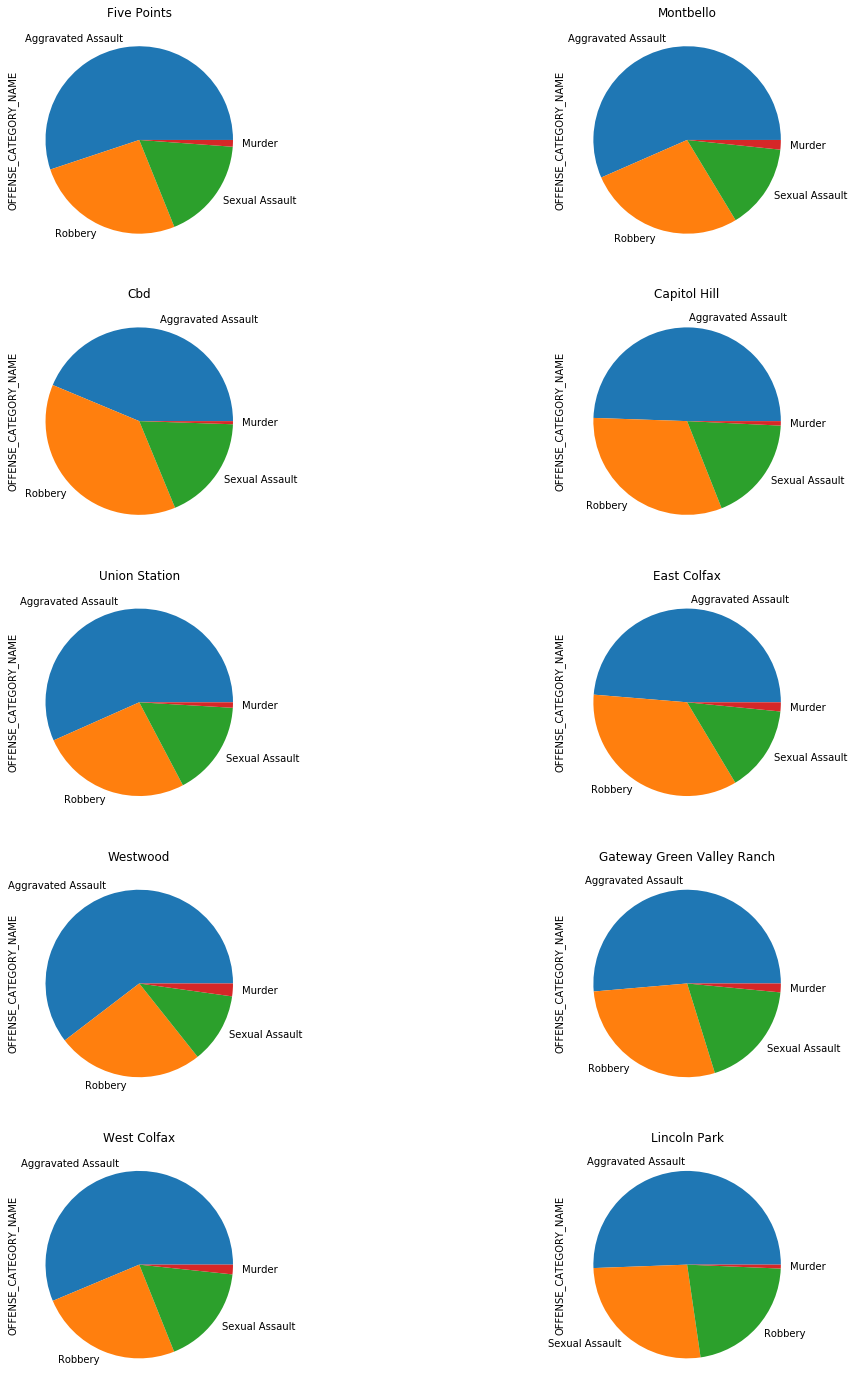

In [420]:
plt.figure(figsize=(18,25))
graph_ct = 1
for value in v_crime.NEIGHBORHOOD_NAME.value_counts().nlargest(10).index:
    plt.subplot(5, 2, graph_ct)
    v_cats_from_n(value).plot(kind='pie', title=value)
    graph_ct += 1
plt.show()